# Quick Demo: Load & View 10 Movies

This notebook provides a **quick test** to verify your setup works:
- Load 10 movies from TMDB CSV
- Display movie metadata (title, genres, overview)
- Show TMDB ratings from CSV
- Demonstrate smart rating selection logic

**Runtime:** ~2 minutes

## Step 1: Setup

In [9]:
import sys
from pathlib import Path
import os
from dotenv import load_dotenv

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Load environment variables ONCE at the top
load_dotenv(project_root / '.env', override=True)

import pandas as pd
from database.db import SessionLocal, init_db
from database.models import Movie
from data_ingestion.tmdb_loader import TMDBDataLoader

print("✅ Imports successful!")
print(f"📁 Project root: {project_root}")

# Check API keys (DO NOT PRINT THE ACTUAL KEY!)
openai_api_key = os.getenv('OPENAI_API_KEY')

if openai_api_key:
    print(f"✅ OpenAI API key loaded successfully")
else:
    print("⚠️  Warning: OPENAI_API_KEY not found in .env file")


✅ Imports successful!
📁 Project root: /Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/hybrid-rec-sys
✅ OpenAI API key loaded successfully


## Step 2: Check CSV File

Make sure your TMDB CSV is in the `data/` folder.

In [10]:
# Check if CSV exists
try:
    csv_path = project_root / "data" / "tmdb_commercial_movies_2016_2024.csv"
    
    if csv_path.exists():
        print(f"✅ CSV found: {csv_path.name}")
        print(f"   Size: {csv_path.stat().st_size / (1024*1024):.1f} MB")
    else:
        print(f"❌ CSV not found!")
        print(f"\nPlease copy your CSV to:")
        print(f"   {csv_path}")
        print(f"\nCommand:")
        print(f"   cp ~/Downloads/tmdb_commercial_movies_2016_2024.csv {project_root}/data/")
except Exception as e:
    print(f"❌ Error checking CSV: {e}")
    print(f"   Make sure you ran Step 1 first!")

✅ CSV found: tmdb_commercial_movies_2016_2024.csv
   Size: 1.1 MB


## Step 3: Load CSV Preview

Let's peek at the CSV structure without loading into database yet.

In [11]:
# Load CSV with pandas to inspect
if csv_path.exists():
    df = pd.read_csv(csv_path)
    
    print(f"📊 CSV Statistics:")
    print(f"   Total rows: {len(df):,}")
    print(f"   Columns: {len(df.columns)}")
    print(f"\n📋 Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i}. {col}")
    
    print(f"\n🎬 First 3 movies:")
    display(df.head(3)[['title', 'release_date', 'vote_average', 'vote_count']].head(3))

📊 CSV Statistics:
   Total rows: 2,188
   Columns: 19

📋 Column names:
   1. tmdb_id
   2. title
   3. original_title
   4. release_date
   5. year
   6. original_language
   7. genres
   8. budget
   9. revenue_worldwide
   10. runtime
   11. popularity
   12. vote_average
   13. vote_count
   14. production_companies
   15. production_countries
   16. director
   17. top_3_cast
   18. overview
   19. adult

🎬 First 3 movies:


,title,release_date,vote_average,vote_count
0,Zootopia,2016-02-11,7.755,17200
1,Your Name.,2016-08-26,8.480,12136
2,Now You See Me 2,2016-06-02,6.827,11211


## Step 4: Initialize Database & Clear Old Data

Create the database schema and clear any existing data for a fresh start.

⚠️ **IMPORTANT:** Run this step **ONCE** before scraping to avoid duplicates!
- If you re-run scraping steps (11a, 11b) multiple times, they will now skip duplicates automatically
- But for a completely fresh start, run this step to clear everything

In [12]:
# Reload modules to get latest code changes
import importlib
import sys

# Remove cached modules
for module in list(sys.modules.keys()):
    if module.startswith('database') or module.startswith('data_ingestion'):
        del sys.modules[module]

# Re-import
from database.db import SessionLocal, init_db, DEFAULT_DB_PATH
from database.models import Movie, Review, MovieSearchTerm

# Check if database exists and has old schema
db_path = project_root / "data" / "database" / "movie_recommender.db"

if db_path.exists():
    print(f"⚠️  Found existing database at: {db_path}")
    print("   This database might not have the new sentiment analysis columns.")
    print("   Deleting old database to create fresh one with new schema...")
    db_path.unlink()
    print("   ✅ Old database deleted!")

# Initialize database with new schema
print("\n🗄️  Initializing database with new schema...")
init_db()

# CLEAR ALL EXISTING DATA for fresh start (should be empty since we deleted the file)
print("🧹 Clearing existing database data (if any)...")
db = SessionLocal()
try:
    # Count existing records
    movie_count = db.query(Movie).count()
    review_count = db.query(Review).count()
    search_term_count = db.query(MovieSearchTerm).count()
    
    if movie_count > 0 or review_count > 0 or search_term_count > 0:
        # Delete all records (cascades to related tables due to relationships)
        db.query(Review).delete()
        db.query(MovieSearchTerm).delete()
        db.query(Movie).delete()
        db.commit()
        
        print(f"   ✅ Deleted {movie_count} movies")
        print(f"   ✅ Deleted {review_count} reviews")
        print(f"   ✅ Deleted {search_term_count} search terms")
    
    print("   ✅ Database cleared - starting fresh!")
except Exception as e:
    print(f"   ⚠️  Error clearing database: {e}")
    db.rollback()
finally:
    db.close()

print("\n✅ Database initialized with new schema (including sentiment columns)!")
print(f"📊 Current database: 0 movies")
print("\n💡 New columns added:")
print("   Movies table: rt_tomatometer, rt_tomatometer_out_of_10,")
print("                 sentiment_imdb_avg, sentiment_rt_top_critics_avg,")
print("                 sentiment_rt_all_critics_avg, sentiment_rt_verified_audience_avg,")
print("                 sentiment_rt_all_audience_avg")
print("   Reviews table: review_category")

⚠️  Found existing database at: /Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/hybrid-rec-sys/data/database/movie_recommender.db
   This database might not have the new sentiment analysis columns.
   Deleting old database to create fresh one with new schema...
   ✅ Old database deleted!

🗄️  Initializing database with new schema...
🧹 Clearing existing database data (if any)...
   ✅ Database cleared - starting fresh!

✅ Database initialized with new schema (including sentiment columns)!
📊 Current database: 0 movies

💡 New columns added:
   Movies table: rt_tomatometer, rt_tomatometer_out_of_10,
                 sentiment_imdb_avg, sentiment_rt_top_critics_avg,
                 sentiment_rt_all_critics_avg, sentiment_rt_verified_audience_avg,
                 sentiment_rt_all_audience_avg
   Reviews table: review_category


## Step 5: Load 10 Random Movies into Database

We'll load 10 **randomly selected** movies for variety in testing.

In [13]:
if csv_path.exists():
    # Load and parse CSV
    loader = TMDBDataLoader(str(csv_path))
    loader.load_csv()
    
    print("📥 Loading 10 RANDOM movies into database...\n")
    
    db = SessionLocal()
    try:
        # Select 10 random movies from the CSV
        random_movies = loader.df.sample(n=10, random_state=None)
        
        loaded = 0
        for idx, row in random_movies.iterrows():
            movie_data = loader.parse_movie(row)
            if not movie_data:
                continue
            
            # Check if exists
            existing = db.query(Movie).filter(
                Movie.title == movie_data['title'],
                Movie.release_year == movie_data['release_year']
            ).first()
            
            if existing:
                print(f"   ⏭️  Skipped (exists): {movie_data['title']}")
                continue
            
            # Create movie
            movie = Movie(
                title=movie_data['title'],
                release_year=movie_data['release_year'],
                genres='|'.join(movie_data['genres']) if movie_data['genres'] else None,
                overview=movie_data['overview'],
                tmdb_rating=movie_data['tmdb_rating'],
                tmdb_vote_count=movie_data['tmdb_vote_count'],
                popularity=movie_data['popularity'],
                runtime=movie_data['runtime'],
                language=movie_data['language']
            )
            db.add(movie)
            loaded += 1
            print(f"   ✅ Added: {movie_data['title']} ({movie_data['release_year']})")
        
        db.commit()
        print(f"\n✅ Successfully loaded {loaded} new random movies!")
        
    except Exception as e:
        print(f"❌ Error: {e}")
        db.rollback()
    finally:
        db.close()


📥 Loading 10 RANDOM movies into database...

   ✅ Added: Silent Night (2023)
   ✅ Added: Whiskey Tango Foxtrot (2016)
   ✅ Added: The Sadness (2021)
   ✅ Added: The Lodgers (2017)
   ✅ Added: The Nun (2018)
   ✅ Added: Monkey Man (2024)
   ✅ Added: Gold (2016)
   ✅ Added: Anatomy of a Fall (2023)
   ✅ Added: A Taxi Driver (2017)
   ✅ Added: Gran Turismo (2023)

✅ Successfully loaded 10 new random movies!


## Step 6: View Movies with Ratings

Display the 10 movies with their metadata and rating information.

In [14]:
# Fetch movies
db = SessionLocal()
movies = db.query(Movie).limit(10).all()
db.close()

print(f"🎬 Showing {len(movies)} movies:\n")
print("=" * 100)

for i, movie in enumerate(movies, 1):
    print(f"\n{i}. {movie.title} ({movie.release_year})")
    print(f"   📁 Genres: {movie.genres or 'N/A'}")
    
    if movie.overview:
        overview_preview = movie.overview[:150] + "..." if len(movie.overview) > 150 else movie.overview
        print(f"   📖 Overview: {overview_preview}")
    
    # Get rating metadata
    rating_info = movie.get_rating_metadata()
    
    print(f"\n   ⭐ Recommended Rating: {rating_info['recommended_rating']}/10")
    
    # Show all rating sources
    if rating_info['sources']:
        print(f"   📊 Rating Sources:")
        for source in rating_info['sources']:
            votes = f"{source['votes']:,}" if source['votes'] else "N/A"
            age = f"{source['age_days']} days ago" if source['age_days'] is not None else "unknown age"
            source_name = source['source'].replace('_', ' ').title()
            print(f"      • {source_name}: {source['rating']}/10 ({votes} votes, {age})")
    
    # Show difference if both ratings exist
    if 'difference' in rating_info and rating_info['difference'] > 0:
        print(f"\n   ℹ️  {rating_info['note']} (difference: {rating_info['difference']})")
    
    print("   " + "-" * 96)

🎬 Showing 10 movies:


1. Silent Night (2023)
   📁 Genres: Action|Thriller|Crime
   📖 Overview: A tormented father witnesses his young son die when caught in a gang's crossfire on Christmas Eve. While recovering from a wound that costs him his vo...

   ⭐ Recommended Rating: 6.173/10
   📊 Rating Sources:
      • Tmdb Csv: 6.173/10 (882 votes, unknown age)
   ------------------------------------------------------------------------------------------------

2. Whiskey Tango Foxtrot (2016)
   📁 Genres: Comedy|Drama|War
   📖 Overview: In 2002, cable news producer Kim Barker decides to shake up her routine by taking a daring new assignment in Kabul, Afghanistan. Dislodged from her co...

   ⭐ Recommended Rating: 6.3/10
   📊 Rating Sources:
      • Tmdb Csv: 6.3/10 (1,012 votes, unknown age)
   ------------------------------------------------------------------------------------------------

3. The Sadness (2021)
   📁 Genres: Horror|Thriller
   📖 Overview: A young couple is pushed to the limit

## Step 7: Create DataFrame for Analysis

Convert to pandas for easy analysis and visualization.

In [15]:
# Create DataFrame
db = SessionLocal()
movies = db.query(Movie).limit(10).all()
db.close()

data = []
for movie in movies:
    rating_info = movie.get_rating_metadata()
    data.append({
        'title': movie.title,
        'year': movie.release_year,
        'genres': movie.genres,
        'rating': rating_info['recommended_rating'],
        'tmdb_rating': movie.tmdb_rating,
        'tmdb_votes': movie.tmdb_vote_count,
        'imdb_rating': movie.imdb_rating,
        'imdb_votes': movie.imdb_vote_count,
        'popularity': movie.popularity
    })

df_movies = pd.DataFrame(data)
print("📊 Movie DataFrame:")
display(df_movies[['title', 'year', 'rating', 'tmdb_rating', 'tmdb_votes']])

📊 Movie DataFrame:


,title,year,rating,tmdb_rating,tmdb_votes
0,Silent Night,2023,6.173,6.173,882
1,Whiskey Tango Foxtrot,2016,6.300,6.300,1012
2,The Sadness,2021,6.821,6.821,1028
3,The Lodgers,2017,5.038,5.038,502
4,The Nun,2018,5.908,5.908,7031
5,Monkey Man,2024,6.886,6.886,1262
6,Gold,2016,6.622,6.622,1703
7,Anatomy of a Fall,2023,7.541,7.541,3028
8,A Taxi Driver,2017,8.046,8.046,1093
9,Gran Turismo,2023,7.700,7.700,3180


## Step 8: Basic Visualizations

Simple charts to visualize the data.

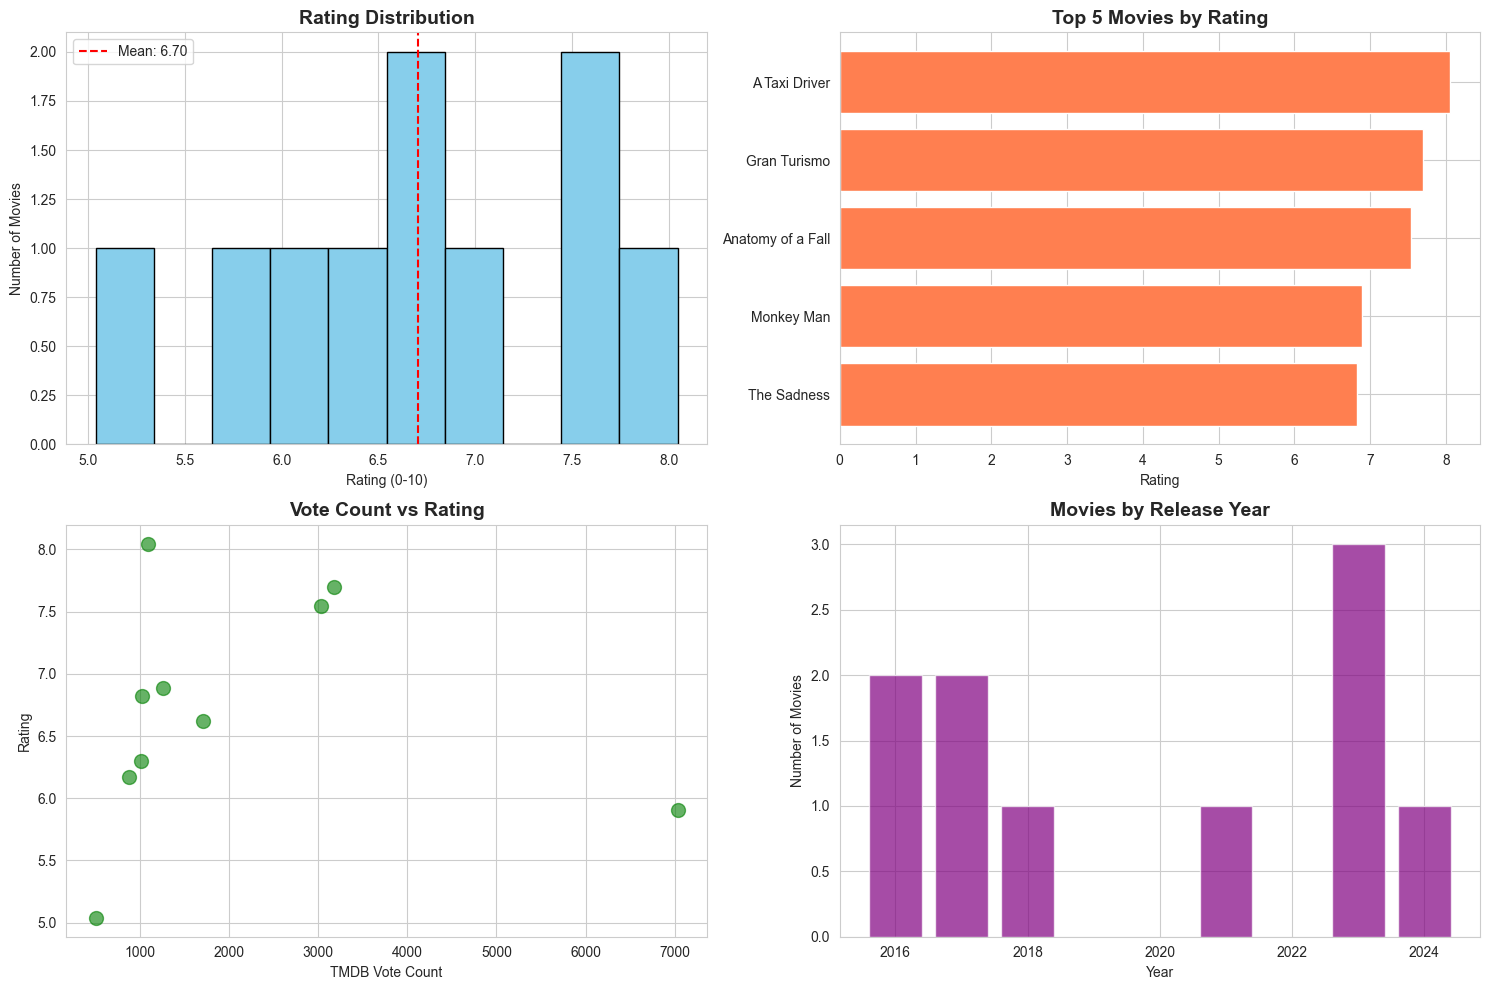


✅ Visualizations complete!


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rating Distribution
ax1 = axes[0, 0]
df_movies['rating'].hist(bins=10, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Rating Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rating (0-10)')
ax1.set_ylabel('Number of Movies')
ax1.axvline(df_movies['rating'].mean(), color='red', linestyle='--', label=f"Mean: {df_movies['rating'].mean():.2f}")
ax1.legend()

# 2. Top Movies by Rating
ax2 = axes[0, 1]
top_movies = df_movies.nlargest(5, 'rating')
ax2.barh(top_movies['title'], top_movies['rating'], color='coral')
ax2.set_title('Top 5 Movies by Rating', fontsize=14, fontweight='bold')
ax2.set_xlabel('Rating')
ax2.invert_yaxis()

# 3. Vote Count vs Rating
ax3 = axes[1, 0]
ax3.scatter(df_movies['tmdb_votes'], df_movies['rating'], s=100, alpha=0.6, color='green')
ax3.set_title('Vote Count vs Rating', fontsize=14, fontweight='bold')
ax3.set_xlabel('TMDB Vote Count')
ax3.set_ylabel('Rating')

# 4. Movies by Year
ax4 = axes[1, 1]
year_counts = df_movies['year'].value_counts().sort_index()
ax4.bar(year_counts.index, year_counts.values, color='purple', alpha=0.7)
ax4.set_title('Movies by Release Year', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year')
ax4.set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete!")

## ✅ Quick Test Complete!

**What we verified:**
- ✅ CSV loading works
- ✅ Movie parsing extracts metadata correctly
- ✅ TMDB ratings loaded from CSV
- ✅ Smart rating selection logic working
- ✅ Database operations successful

**Next Steps:**
1. Open `02_full_pipeline_demo.ipynb` for complete scraping demo
2. Or proceed to scrape more movies with real data

## Summary Statistics

In [17]:
print("📊 SUMMARY STATISTICS")
print("=" * 60)
print(f"Total movies loaded: {len(df_movies)}")
print(f"Average rating: {df_movies['rating'].mean():.2f}/10")
print(f"Rating range: {df_movies['rating'].min():.1f} - {df_movies['rating'].max():.1f}")
print(f"Total votes (TMDB): {df_movies['tmdb_votes'].sum():,}")
print(f"Average votes per movie: {df_movies['tmdb_votes'].mean():,.0f}")
print()

# Genre analysis
print("🎭 GENRE BREAKDOWN:")
all_genres = []
for genres_str in df_movies['genres'].dropna():
    all_genres.extend(genres_str.split('|'))

from collections import Counter
genre_counts = Counter(all_genres)
for genre, count in genre_counts.most_common():
    print(f"   {genre}: {count} movies")

📊 SUMMARY STATISTICS
Total movies loaded: 10
Average rating: 6.70/10
Rating range: 5.0 - 8.0
Total votes (TMDB): 20,721
Average votes per movie: 2,072

🎭 GENRE BREAKDOWN:
   Thriller: 6 movies
   Action: 4 movies
   Drama: 4 movies
   Horror: 3 movies
   Crime: 2 movies
   Mystery: 2 movies
   Adventure: 2 movies
   Comedy: 1 movies
   War: 1 movies
   History: 1 movies


---

## Part 2: Test Scraping Pipeline

Now let's test the scraping functionality on a few movies.

## Step 9: Import Scraping Modules

In [18]:
# Reload scraper modules to get latest code changes
import importlib

# Remove cached scraper modules
for module in list(sys.modules.keys()):
    if 'scrapers' in module:
        del sys.modules[module]

# Import scraping modules
from scrapers.imdb_scraper import IMDbScraper
from database.models import Review, MovieSearchTerm
from datetime import datetime

print("✅ Scraping modules imported and reloaded!")


✅ Scraping modules imported and reloaded!


## Step 10: Select Movies for Scraping

Select random movies from the database to test the scraping pipeline.

In [19]:
# Select movies for scraping
db = SessionLocal()
all_movies = db.query(Movie).all()
db.close()

import random
TEST_MOVIES = min(10, len(all_movies))
movies_to_scrape = random.sample(all_movies, TEST_MOVIES)

print(f"✅ Selected {TEST_MOVIES} random movies for scraping\n")
print(f"📽️  Movies to scrape:")
for i, movie in enumerate(movies_to_scrape, 1):
    print(f"   {i}. {movie.title} ({movie.release_year})")

✅ Selected 10 random movies for scraping

📽️  Movies to scrape:
   1. A Taxi Driver (2017)
   2. Monkey Man (2024)
   3. Silent Night (2023)
   4. Gold (2016)
   5. The Nun (2018)
   6. Gran Turismo (2023)
   7. Whiskey Tango Foxtrot (2016)
   8. The Lodgers (2017)
   9. Anatomy of a Fall (2023)
   10. The Sadness (2021)


## Step 11: Scrape IMDb Ratings (Concurrent)

Fetch live ratings from IMDb for these movies.
**Scrapes up to 3 movies concurrently** to respect rate limits!

In [20]:
# Initialize IMDb scraper
imdb = IMDbScraper()

print(f"🎬 Scraping IMDb ratings for {TEST_MOVIES} movies concurrently...\n")

# Get the same random movies
db = SessionLocal()
movies_to_scrape = [db.query(Movie).filter(Movie.id == m.id).first() for m in movies_to_scrape]
db.close()

# Concurrent IMDb scraping
from concurrent.futures import ThreadPoolExecutor, as_completed

successful_imdb = 0
failed_imdb = 0

def scrape_imdb_for_movie(movie):
    """Scrape IMDb rating for a single movie"""
    try:
        print(f"📽️  Starting IMDb: {movie.title} ({movie.release_year})")
        
        # Scrape IMDb data
        imdb_data = imdb.scrape_movie_rating(
            title=movie.title,
            year=movie.release_year
        )
        
        if imdb_data and imdb_data.get('rating'):
            print(f"   ✅ {movie.title}: {imdb_data['rating']}/10 ({imdb_data.get('vote_count', 'N/A'):,} votes)")
            return (movie, imdb_data, True)
        else:
            print(f"   ⚠️  {movie.title}: No IMDb rating found")
            return (movie, None, False)
            
    except Exception as e:
        print(f"   ❌ {movie.title}: Error - {str(e)[:100]}")
        return (movie, None, False)

# Run concurrent scraping (max 3 concurrent to avoid rate limiting)
imdb_results = []
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(scrape_imdb_for_movie, movie): movie for movie in movies_to_scrape}
    
    for future in as_completed(futures):
        imdb_results.append(future.result())

print("\n" + "="*80)
print("📊 Saving IMDb results to database...")

# Save all successful results to database
db = SessionLocal()
try:
    for movie, imdb_data, success in imdb_results:
        if success and imdb_data:
            # Get the movie from this session
            movie_obj = db.query(Movie).filter(Movie.id == movie.id).first()
            if movie_obj:
                movie_obj.imdb_rating = imdb_data['rating']
                movie_obj.imdb_vote_count = imdb_data.get('vote_count')
                movie_obj.imdb_id = imdb_data.get('imdb_id')
                movie_obj.scraped_at = datetime.now()
                successful_imdb += 1
        else:
            failed_imdb += 1
    
    db.commit()
    print(f"✅ IMDb ratings updated!")
    print(f"   Successful: {successful_imdb}/{TEST_MOVIES}")
    print(f"   Failed: {failed_imdb}/{TEST_MOVIES}")
    
except Exception as e:
    print(f"❌ Database error: {e}")
    db.rollback()
finally:
    db.close()


🎬 Scraping IMDb ratings for 10 movies concurrently...

📽️  Starting IMDb: A Taxi Driver (2017)
📽️  Starting IMDb: Monkey Man (2024)
📽️  Starting IMDb: Silent Night (2023)
2025-12-08 00:08:27 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Monkey Man' (2024): tt9214772
2025-12-08 00:08:27 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Monkey Man' (2024): tt9214772
2025-12-08 00:08:28 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Silent Night' (2023): tt15799866
2025-12-08 00:08:28 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'Silent Night' (2023): tt15799866
2025-12-08 00:08:29 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'A Taxi Driver' (2017): tt6878038
2025-12-08 00:08:29 - scrapers.imdb_scraper - INFO - Found released movie IMDb ID for 'A Taxi Driver' (2017): tt6878038
2025-12-08 00:08:30 - scrapers.imdb_scraper - INFO - Scraped rating for tt9214772: 6.8/10 (97682 votes)
2025-12-08 

## Step 11a: Scrape IMDb Reviews (Concurrent)

Now let's scrape detailed **user reviews** from IMDb for deeper analysis.
**Scrapes up to 3 movies concurrently** with up to 30 reviews per movie!

In [21]:
print(f"📝 Scraping IMDb REVIEWS for {TEST_MOVIES} movies concurrently...\n")

# Get movies that have IMDb IDs (query fresh from database)
db = SessionLocal()
movies_with_imdb = db.query(Movie).filter(Movie.imdb_id.isnot(None)).limit(TEST_MOVIES).all()
db.close()

if not movies_with_imdb:
    print("⚠️  No movies with IMDb IDs found. Run Step 11 first!")
else:
    # Concurrent IMDb review scraping
    successful_imdb_reviews = 0
    total_reviews_scraped = 0
    skipped_duplicates = 0
    
    def scrape_imdb_reviews_for_movie(movie):
        """Scrape IMDb reviews for a single movie"""
        try:
            print(f"📽️  Starting IMDb Reviews: {movie.title} ({movie.release_year})")
            
            # Scrape reviews (max 30 per movie)
            reviews_data = imdb.scrape_reviews(
                imdb_id=movie.imdb_id,
                max_reviews=30
            )
            
            if reviews_data:
                print(f"   ✅ {movie.title}: Scraped {len(reviews_data)} reviews")
                return (movie, reviews_data, True)
            else:
                print(f"   ⚠️  {movie.title}: No reviews found")
                return (movie, [], False)
                
        except Exception as e:
            print(f"   ❌ {movie.title}: Error - {str(e)[:100]}")
            return (movie, [], False)
    
    # Run concurrent scraping (max 3 concurrent)
    imdb_review_results = []
    with ThreadPoolExecutor(max_workers=3) as executor:
        futures = {executor.submit(scrape_imdb_reviews_for_movie, movie): movie 
                   for movie in movies_with_imdb}
        
        for future in as_completed(futures):
            imdb_review_results.append(future.result())
    
    print("\n" + "="*80)
    print("📊 Saving IMDb reviews to database...")
    
    # Save all successful results to database
    db = SessionLocal()
    try:
        for movie, reviews_data, success in imdb_review_results:
            if success and reviews_data:
                # Get the movie from this session
                movie_obj = db.query(Movie).filter(Movie.id == movie.id).first()
                if movie_obj:
                    for review_data in reviews_data:
                        # Check if review already exists (prevent duplicates)
                        existing_review = db.query(Review).filter(
                            Review.movie_id == movie_obj.id,
                            Review.source == 'imdb',
                            Review.author == review_data.get('author'),
                            Review.text == review_data.get('text')
                        ).first()
                        
                        if existing_review:
                            skipped_duplicates += 1
                            continue
                        
                        # Create Review object
                        review = Review(
                            movie_id=movie_obj.id,
                            source='imdb',
                            source_id=review_data.get('source_id'),
                            text=review_data.get('text'),
                            rating=review_data.get('rating'),
                            author=review_data.get('author'),
                            review_date=review_data.get('review_date'),
                            helpful_count=review_data.get('helpful_count', 0),
                            review_length=review_data.get('review_length'),
                            word_count=review_data.get('word_count'),
                            scraped_at=datetime.now()
                        )
                        db.add(review)
                        total_reviews_scraped += 1
                    
                    successful_imdb_reviews += 1
        
        db.commit()
        print(f"✅ IMDb reviews saved!")
        print(f"   Movies with reviews: {successful_imdb_reviews}/{len(movies_with_imdb)}")
        print(f"   Total reviews added: {total_reviews_scraped}")
        if skipped_duplicates > 0:
            print(f"   ⏭️  Skipped duplicates: {skipped_duplicates}")
        
    except Exception as e:
        print(f"❌ Database error: {e}")
        db.rollback()
    finally:
        db.close()

📝 Scraping IMDb REVIEWS for 10 movies concurrently...

📽️  Starting IMDb Reviews: Silent Night (2023)
📽️  Starting IMDb Reviews: Whiskey Tango Foxtrot (2016)
📽️  Starting IMDb Reviews: The Sadness (2021)
2025-12-08 00:08:54 - scrapers.imdb_scraper - INFO - Scraped 24 reviews from IMDb for tt13872248
2025-12-08 00:08:54 - scrapers.imdb_scraper - INFO - Scraped 24 reviews from IMDb for tt13872248
   ✅ The Sadness: Scraped 24 reviews
📽️  Starting IMDb Reviews: The Lodgers (2017)
2025-12-08 00:08:54 - scrapers.imdb_scraper - INFO - Scraped 25 reviews from IMDb for tt3553442
   ✅ The Sadness: Scraped 24 reviews
📽️  Starting IMDb Reviews: The Lodgers (2017)
2025-12-08 00:08:54 - scrapers.imdb_scraper - INFO - Scraped 25 reviews from IMDb for tt3553442
   ✅ Whiskey Tango Foxtrot: Scraped 25 reviews
📽️  Starting IMDb Reviews: The Nun (2018)
   ✅ Whiskey Tango Foxtrot: Scraped 25 reviews
📽️  Starting IMDb Reviews: The Nun (2018)
2025-12-08 00:08:55 - scrapers.imdb_scraper - INFO - Scraped 25 re

## Step 11b: Scrape Rotten Tomatoes Reviews (Concurrent)

Scrape both **critic** and **audience** reviews from Rotten Tomatoes.
**Scrapes up to 3 movies concurrently** with up to 20 reviews per movie!

## Step 11a: Scrape Rotten Tomatoes Tomatometer Scores

Get the official RT critics score (Tomatometer) for each movie and store it in the database.

In [23]:
print("=" * 80)
print("🍅 SCRAPING ROTTEN TOMATOES TOMATOMETER SCORES")
print("=" * 80)

from scrapers.rotten_tomatoes_selenium import RottenTomatoesSeleniumScraper

# Initialize scraper
rt_scraper = RottenTomatoesSeleniumScraper(headless=True)

# Get movies from database
db = SessionLocal()
try:
    movies_to_score = db.query(Movie).all()
    
    if not movies_to_score:
        print("⚠️  No movies found in database. Please load movies first (run earlier cells).")
    else:
        print(f"📊 Found {len(movies_to_score)} movies to score")
        
        rt_score_results = []
        
        for i, movie in enumerate(movies_to_score, 1):
            print(f"\n📽️  [{i}/{len(movies_to_score)}] Getting RT score: {movie.title} ({movie.release_year})")
            
            try:
                # Search for movie to get slug
                movie_slug = rt_scraper.search_movie(movie.title, movie.release_year)
                
                if movie_slug:
                    # Get the Tomatometer score
                    rt_score = rt_scraper.get_tomatometer_score(movie_slug)
                    
                    if rt_score is not None:
                        # Convert to 0-10 scale
                        rt_score_out_of_10 = round(rt_score / 10.0, 2)
                        
                        # Update movie in database
                        movie.rt_tomatometer = rt_score
                        movie.rt_tomatometer_out_of_10 = rt_score_out_of_10
                        db.commit()
                        
                        print(f"   ✅ RT Score: {rt_score}% (out of 10: {rt_score_out_of_10})")
                        rt_score_results.append({
                            'movie': movie.title,
                            'rt_score': rt_score,
                            'rt_score_out_of_10': rt_score_out_of_10
                        })
                    else:
                        print(f"   ⚠️  Could not find RT score")
                else:
                    print(f"   ⚠️  Could not find movie on RT")
            
            except Exception as e:
                print(f"   ❌ Error: {str(e)[:100]}")
                continue
        
        # Summary
        print("\n" + "=" * 80)
        print("📊 RT Tomatometer Scraping Summary")
        print(f"✅ Scores found: {len(rt_score_results)}/{len(movies_to_score)}")
        print("=" * 80)

finally:
    db.close()
    # Close selenium driver
    if hasattr(rt_scraper, 'driver') and rt_scraper.driver:
        rt_scraper._close_driver()

🍅 SCRAPING ROTTEN TOMATOES TOMATOMETER SCORES
2025-12-08 00:10:12 - scrapers.rotten_tomatoes_selenium - INFO - Initializing Rotten Tomatoes Selenium scraper
📊 Found 10 movies to score

📽️  [1/10] Getting RT score: Silent Night (2023)
2025-12-08 00:10:12 - scrapers.rotten_tomatoes_selenium - INFO - 🔍 Strategy 1: Searching without year for 'Silent Night'
2025-12-08 00:10:12 - scrapers.rotten_tomatoes_selenium - INFO - Setting up Chrome WebDriver...
📊 Found 10 movies to score

📽️  [1/10] Getting RT score: Silent Night (2023)
2025-12-08 00:10:12 - scrapers.rotten_tomatoes_selenium - INFO - 🔍 Strategy 1: Searching without year for 'Silent Night'
2025-12-08 00:10:12 - scrapers.rotten_tomatoes_selenium - INFO - Setting up Chrome WebDriver...
2025-12-08 00:10:14 - scrapers.rotten_tomatoes_selenium - INFO - ✅ Chrome WebDriver initialized
2025-12-08 00:10:14 - scrapers.rotten_tomatoes_selenium - INFO - Searching RT: https://www.rottentomatoes.com/search?search=Silent%20Night
2025-12-08 00:10:14 

In [24]:
# Import Rotten Tomatoes scraper (configured version)
import yaml
from sqlalchemy.exc import IntegrityError

# Load configuration to determine which scraper to use
config_path = project_root / "config" / "config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

scraper_type = config.get('scraping', {}).get('rotten_tomatoes_scraper', 'beautifulsoup')
use_selenium = (scraper_type.lower() == 'selenium')

if use_selenium:
    print("🔧 Using Selenium scraper (JavaScript-rendered content)")
    try:
        from scrapers.rotten_tomatoes_selenium import RottenTomatoesSeleniumScraper
        rt_scraper = RottenTomatoesSeleniumScraper(
            headless=config.get('scraping', {}).get('selenium', {}).get('headless', True)
        )
        print("✅ Selenium scraper initialized")
    except ImportError as e:
        print("❌ Selenium not installed!")
        print("   Install with: pip install selenium webdriver-manager")
        print(f"   Error: {e}")
        raise
else:
    print("🔧 Using BeautifulSoup scraper (static HTML - won't find reviews)")
    from scrapers.rotten_tomatoes_scraper import RottenTomatoesScraper
    rt_scraper = RottenTomatoesScraper()
    print("⚠️  Note: BeautifulSoup cannot access JavaScript-rendered reviews")
    print("   Set rotten_tomatoes_scraper='selenium' in config.yaml to fix this")

print(f"\n🍅 Scraping Rotten Tomatoes REVIEWS for {TEST_MOVIES} movies concurrently...")
print("📌 NOTE: RT scraper collects from 4 endpoints:")
print("   • top-critics (highest priority)")
print("   • all-critics")
print("   • verified-audience (highest priority)")
print("   • all-audience")
print("   Duplicates are automatically removed, priorities preserved.\n")

# Get movies from database (fresh query)
db = SessionLocal()
movies_for_rt = db.query(Movie).limit(TEST_MOVIES).all()
db.close()

# Concurrent Rotten Tomatoes review scraping
successful_rt_reviews = 0
total_rt_reviews_scraped = 0
skipped_rt_duplicates = 0
priority_distribution = {'top_critic': 0, 'critic': 0, 'verified_audience': 0, 'audience': 0}

def scrape_rt_reviews_for_movie(movie):
    """Scrape Rotten Tomatoes reviews for a single movie"""
    try:
        print(f"📽️  Starting RT Reviews: {movie.title} ({movie.release_year})")
        
        # Scrape both critic and audience reviews (max 20 per endpoint)
        reviews_data = rt_scraper.scrape_movie_reviews(
            title=movie.title,
            year=movie.release_year,
            max_reviews=20
        )
        
        if reviews_data:
            # Count by priority level
            top_critic = len([r for r in reviews_data if r.get('review_type') == 'top_critic'])
            critic = len([r for r in reviews_data if r.get('review_type') == 'critic'])
            verified = len([r for r in reviews_data if r.get('review_type') == 'verified_audience'])
            audience = len([r for r in reviews_data if r.get('review_type') == 'audience'])
            
            print(f"   ✅ {movie.title}: {len(reviews_data)} reviews")
            print(f"      Critics: {top_critic} top + {critic} regular")
            print(f"      Audience: {verified} verified + {audience} regular")
            return (movie, reviews_data, True)
        else:
            print(f"   ⚠️  {movie.title}: No reviews found")
            return (movie, [], False)
            
    except Exception as e:
        print(f"   ❌ {movie.title}: Error - {str(e)[:100]}")
        import traceback
        traceback.print_exc()
        return (movie, [], False)

# Run concurrent scraping (max 3 concurrent)
rt_review_results = []
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(scrape_rt_reviews_for_movie, movie): movie 
               for movie in movies_for_rt}
    
    for future in as_completed(futures):
        try:
            rt_review_results.append(future.result())
        except Exception as e:
            print(f"❌ Future error: {e}")
            traceback.print_exc()

print("\n" + "="*80)
print("📊 Saving Rotten Tomatoes reviews to database...")

# Save all successful results to database
db = SessionLocal()
try:
    for movie, reviews_data, success in rt_review_results:
        if success and reviews_data:
            # Get the movie from this session
            movie_obj = db.query(Movie).filter(Movie.id == movie.id).first()
            if movie_obj:
                for review_data in reviews_data:
                    try:
                        # Validate required fields first
                        if not review_data.get('text'):
                            continue
                        
                        source_id = review_data.get('source_id')
                        
                        # Check if review already exists by source_id (unique constraint)
                        if source_id:
                            existing_review = db.query(Review).filter(
                                Review.source_id == source_id
                            ).first()
                            
                            if existing_review:
                                skipped_rt_duplicates += 1
                                continue
                        
                        # Track priority distribution
                        priority = review_data.get('review_type', 'unknown')
                        if priority in priority_distribution:
                            priority_distribution[priority] += 1
                        
                        # Create Review object
                        review = Review(
                            movie_id=movie_obj.id,
                            source='rotten_tomatoes',
                            source_id=source_id,
                            review_category=priority,  # Store RT category (top_critics, all_critics, etc.)
                            text=review_data.get('text'),
                            rating=review_data.get('rating'),
                            title=review_data.get('title'),
                            author=review_data.get('author', 'Anonymous'),
                            review_date=review_data.get('review_date'),
                            helpful_count=review_data.get('helpful_count', 0),
                            not_helpful_count=review_data.get('not_helpful_count', 0),
                            review_length=review_data.get('review_length', len(review_data.get('text', ''))),
                            word_count=review_data.get('word_count', len(review_data.get('text', '').split())),
                            scraped_at=datetime.now()
                        )
                        db.add(review)
                        db.flush()  # Flush immediately to catch constraint violations
                        total_rt_reviews_scraped += 1
                        
                    except IntegrityError as e:
                        # Duplicate source_id or other constraint violation
                        db.rollback()  # CRITICAL: Rollback to continue processing
                        skipped_rt_duplicates += 1
                        continue
                        
                    except Exception as e:
                        # Other errors - rollback and continue
                        db.rollback()
                        print(f"   ⚠️  Error adding review: {str(e)[:100]}")
                        continue
                
                successful_rt_reviews += 1
    
    db.commit()
    print(f"✅ Rotten Tomatoes reviews saved!")
    print(f"   Movies with reviews: {successful_rt_reviews}/{len(movies_for_rt)}")
    print(f"   Total reviews added: {total_rt_reviews_scraped}")
    if skipped_rt_duplicates > 0:
        print(f"   ⏭️  Skipped duplicates: {skipped_rt_duplicates}")
    
    # Show priority distribution
    if total_rt_reviews_scraped > 0:
        print(f"\n📊 Priority Distribution:")
        print(f"   Top Critics: {priority_distribution['top_critic']}")
        print(f"   Regular Critics: {priority_distribution['critic']}")
        print(f"   Verified Audience: {priority_distribution['verified_audience']}")
        print(f"   Regular Audience: {priority_distribution['audience']}")
    
except Exception as e:
    print(f"❌ Database error: {e}")
    import traceback
    traceback.print_exc()
    db.rollback()
finally:
    db.close()
    
    # Close Selenium driver if using Selenium
    if use_selenium and hasattr(rt_scraper, 'close'):
        rt_scraper.close()
        print("\n🔒 Selenium driver closed")

🔧 Using Selenium scraper (JavaScript-rendered content)
2025-12-08 00:11:10 - scrapers.rotten_tomatoes_selenium - INFO - Initializing Rotten Tomatoes Selenium scraper
✅ Selenium scraper initialized

🍅 Scraping Rotten Tomatoes REVIEWS for 10 movies concurrently...
📌 NOTE: RT scraper collects from 4 endpoints:
   • top-critics (highest priority)
   • all-critics
   • verified-audience (highest priority)
   • all-audience
   Duplicates are automatically removed, priorities preserved.

📽️  Starting RT Reviews: Silent Night (2023)
2025-12-08 00:11:10 - scrapers.rotten_tomatoes_selenium - INFO - 🔍 Strategy 1: Searching without year for 'Silent Night'
📽️  Starting RT Reviews: Whiskey Tango Foxtrot (2016)
📽️  Starting RT Reviews: The Sadness (2021)
2025-12-08 00:11:10 - scrapers.rotten_tomatoes_selenium - INFO - 🔍 Strategy 1: Searching without year for 'Whiskey Tango Foxtrot'
2025-12-08 00:11:10 - scrapers.rotten_tomatoes_selenium - INFO - Setting up Chrome WebDriver...
✅ Selenium scraper initi

## Step 12: VADER Sentiment Analysis on Reviews

Apply VADER sentiment analysis to all scraped reviews (IMDb + Rotten Tomatoes).

In [26]:
print("=" * 80)
print("🎭 VADER SENTIMENT ANALYSIS")
print("=" * 80)

# Install vaderSentiment if not already installed
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
except ImportError:
    print("📦 Installing vaderSentiment...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "vaderSentiment"])
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Reconnect to database
db = SessionLocal()

try:
    # Get all reviews that need sentiment analysis
    reviews_to_analyze = db.query(Review).filter(Review.sentiment_score.is_(None)).all()
    
    print(f"\n📊 Found {len(reviews_to_analyze)} reviews to analyze")
    
    if len(reviews_to_analyze) == 0:
        print("   ℹ️  All reviews already have sentiment scores!")
    else:
        analyzed_count = 0
        
        for i, review in enumerate(reviews_to_analyze, 1):
            if i % 100 == 0:
                print(f"   Progress: {i}/{len(reviews_to_analyze)}")
            
            try:
                # Run VADER sentiment analysis
                scores = analyzer.polarity_scores(review.text)
                
                # Compound score ranges from -1 (most negative) to +1 (most positive)
                compound_score = scores['compound']
                
                # Determine sentiment label
                if compound_score >= 0.05:
                    sentiment_label = 'positive'
                elif compound_score <= -0.05:
                    sentiment_label = 'negative'
                else:
                    sentiment_label = 'neutral'
                
                # Update review with sentiment
                review.sentiment_score = round(compound_score, 6)  # 6 decimal places
                review.sentiment_label = sentiment_label
                review.sentiment_confidence = round(max(scores['pos'], scores['neg'], scores['neu']), 4)
                
                analyzed_count += 1
                
            except Exception as e:
                print(f"   ⚠️  Error analyzing review {review.id}: {str(e)[:50]}")
                continue
        
        # Commit all updates
        db.commit()
        
        print(f"\n✅ Sentiment analysis complete!")
        print(f"   Analyzed: {analyzed_count} reviews")
    
    # Show distribution
    from sqlalchemy import func
    sentiment_distribution = db.query(
        Review.sentiment_label, 
        func.count(Review.id)
    ).group_by(Review.sentiment_label).all()
    
    print(f"\n📊 Sentiment Distribution:")
    for label, count in sentiment_distribution:
        if label:  # Skip None values
            print(f"   {label.capitalize()}: {count}")

except Exception as e:
    print(f"❌ Error during sentiment analysis: {e}")
    import traceback
    traceback.print_exc()
    db.rollback()
finally:
    db.close()

🎭 VADER SENTIMENT ANALYSIS

📊 Found 531 reviews to analyze
   Progress: 100/531
   Progress: 200/531
   Progress: 300/531
   Progress: 400/531
   Progress: 500/531

✅ Sentiment analysis complete!
   Analyzed: 531 reviews

📊 Sentiment Distribution:
   Negative: 169
   Neutral: 51
   Positive: 311
   Progress: 200/531
   Progress: 300/531
   Progress: 400/531
   Progress: 500/531

✅ Sentiment analysis complete!
   Analyzed: 531 reviews

📊 Sentiment Distribution:
   Negative: 169
   Neutral: 51
   Positive: 311


## Step 13: Calculate Average Sentiment Per Movie

Calculate average sentiment for each movie by source (IMDb, RT categories) and update the movies table.

In [28]:
print("=" * 80)
print("📊 CALCULATING AVERAGE SENTIMENT PER MOVIE")
print("=" * 80)

from sqlalchemy import func

# Reconnect to database
db = SessionLocal()

try:
    # Get all movies that have reviews
    movies_with_reviews = db.query(Movie).join(Review).distinct().all()
    
    print(f"\n📽️  Processing {len(movies_with_reviews)} movies with reviews")
    
    updated_count = 0
    
    for movie in movies_with_reviews:
        print(f"\n{movie.title} ({movie.release_year}):")
        
        # IMDb sentiment average
        imdb_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'imdb',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if imdb_sentiment:
            movie.sentiment_imdb_avg = round(float(imdb_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'imdb',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"   IMDb avg sentiment: {movie.sentiment_imdb_avg:.4f} (n={count})")
        
        # Rotten Tomatoes - separate by review_category
        # Categories: 'top_critic', 'critic', 'verified_audience', 'audience'
        
        # RT Top Critics
        rt_top_critics_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'top_critic',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_top_critics_sentiment:
            movie.sentiment_rt_top_critics_avg = round(float(rt_top_critics_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'top_critic',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"   RT Top Critics avg sentiment: {movie.sentiment_rt_top_critics_avg:.4f} (n={count})")
        
        # RT All Critics
        rt_all_critics_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'critic',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_all_critics_sentiment:
            movie.sentiment_rt_all_critics_avg = round(float(rt_all_critics_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'critic',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"   RT All Critics avg sentiment: {movie.sentiment_rt_all_critics_avg:.4f} (n={count})")
        
        # RT Verified Audience
        rt_verified_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'verified_audience',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_verified_sentiment:
            movie.sentiment_rt_verified_audience_avg = round(float(rt_verified_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'verified_audience',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"   RT Verified Audience avg sentiment: {movie.sentiment_rt_verified_audience_avg:.4f} (n={count})")
        
        # RT All Audience
        rt_audience_sentiment = db.query(func.avg(Review.sentiment_score)).filter(
            Review.movie_id == movie.id,
            Review.source == 'rotten_tomatoes',
            Review.review_category == 'audience',
            Review.sentiment_score.isnot(None)
        ).scalar()
        
        if rt_audience_sentiment:
            movie.sentiment_rt_all_audience_avg = round(float(rt_audience_sentiment), 6)
            
            count = db.query(func.count(Review.id)).filter(
                Review.movie_id == movie.id,
                Review.source == 'rotten_tomatoes',
                Review.review_category == 'audience',
                Review.sentiment_score.isnot(None)
            ).scalar()
            print(f"   RT All Audience avg sentiment: {movie.sentiment_rt_all_audience_avg:.4f} (n={count})")
        
        updated_count += 1
    
    # Commit all updates
    db.commit()
    
    print(f"\n✅ Sentiment averages calculated for {updated_count} movies")
    
    # Show summary statistics
    print("\n" + "=" * 80)
    print("📈 SENTIMENT SUMMARY ACROSS ALL MOVIES")
    print("=" * 80)
    
    # Overall averages
    overall_imdb = db.query(func.avg(Movie.sentiment_imdb_avg)).filter(
        Movie.sentiment_imdb_avg.isnot(None)
    ).scalar()
    
    overall_rt_top = db.query(func.avg(Movie.sentiment_rt_top_critics_avg)).filter(
        Movie.sentiment_rt_top_critics_avg.isnot(None)
    ).scalar()
    
    overall_rt_all = db.query(func.avg(Movie.sentiment_rt_all_critics_avg)).filter(
        Movie.sentiment_rt_all_critics_avg.isnot(None)
    ).scalar()
    
    overall_rt_verified = db.query(func.avg(Movie.sentiment_rt_verified_audience_avg)).filter(
        Movie.sentiment_rt_verified_audience_avg.isnot(None)
    ).scalar()
    
    overall_rt_audience = db.query(func.avg(Movie.sentiment_rt_all_audience_avg)).filter(
        Movie.sentiment_rt_all_audience_avg.isnot(None)
    ).scalar()
    
    if overall_imdb:
        print(f"IMDb Average Sentiment: {float(overall_imdb):.4f}")
    if overall_rt_top:
        print(f"RT Top Critics Average Sentiment: {float(overall_rt_top):.4f}")
    if overall_rt_all:
        print(f"RT All Critics Average Sentiment: {float(overall_rt_all):.4f}")
    if overall_rt_verified:
        print(f"RT Verified Audience Average Sentiment: {float(overall_rt_verified):.4f}")
    if overall_rt_audience:
        print(f"RT All Audience Average Sentiment: {float(overall_rt_audience):.4f}")

except Exception as e:
    print(f"❌ Error calculating sentiment averages: {e}")
    import traceback
    traceback.print_exc()
    db.rollback()
finally:
    db.close()

print("\n" + "=" * 80)
print("✅ ALL SENTIMENT PROCESSING COMPLETE!")
print("=" * 80)

📊 CALCULATING AVERAGE SENTIMENT PER MOVIE

📽️  Processing 10 movies with reviews

Whiskey Tango Foxtrot (2016):
   IMDb avg sentiment: 0.4020 (n=25)
   RT Verified Audience avg sentiment: -0.2079 (n=10)

Gold (2016):
   IMDb avg sentiment: 0.4807 (n=25)

The Lodgers (2017):
   IMDb avg sentiment: -0.1063 (n=24)
   RT Top Critics avg sentiment: -0.0347 (n=11)
   RT All Critics avg sentiment: 0.0746 (n=20)
   RT Verified Audience avg sentiment: 0.2370 (n=19)
   RT All Audience avg sentiment: 0.2050 (n=10)

A Taxi Driver (2017):
   IMDb avg sentiment: 0.5662 (n=25)
   RT Top Critics avg sentiment: 0.2873 (n=6)
   RT All Critics avg sentiment: 0.1322 (n=20)
   RT Verified Audience avg sentiment: 0.6154 (n=10)
   RT All Audience avg sentiment: 0.1537 (n=10)

The Nun (2018):
   IMDb avg sentiment: -0.1613 (n=25)
   RT Top Critics avg sentiment: 0.0746 (n=20)
   RT All Critics avg sentiment: 0.2370 (n=19)
   RT Verified Audience avg sentiment: 0.2050 (n=10)
   RT All Audience avg sentiment: -

## Step 11c: Generate Search Terms for Reddit (Optional - Future Feature)

**💡 This step is for future Reddit scraping.**

Use OpenAI GPT to generate smart search terms for finding movie discussions on Reddit.
This is where your $10 OpenAI credits will be useful!

**To enable later:**
1. Get Reddit API credentials
2. Uncomment and run the cell below
3. Use search terms with the Reddit scraper

In [ ]:
# FUTURE FEATURE - Uncomment when ready to use Reddit API
# from scrapers.openai_search import OpenAISearchTermGenerator
# from concurrent.futures import ThreadPoolExecutor, as_completed
# 
# print(f"🎬 Generating Reddit search terms for {TEST_MOVIES} movies...\n")
# 
# # Initialize OpenAI generator
# openai_generator = OpenAISearchTermGenerator()
# 
# def generate_reddit_terms(movie):
#     """Generate Reddit-specific search terms"""
#     try:
#         print(f"📽️  {movie.title} ({movie.release_year})")
#         
#         search_terms_dict = openai_generator.generate_search_terms(
#             title=movie.title,
#             year=movie.release_year,
#             genres=movie.genres.split('|') if movie.genres else [],
#             overview=movie.overview or ""
#         )
#         
#         if search_terms_dict and 'reddit' in search_terms_dict:
#             reddit_terms = search_terms_dict['reddit']
#             print(f"   ✅ Generated {len(reddit_terms)} Reddit search terms")
#             return (movie, reddit_terms, True)
#         return (movie, [], False)
#     except Exception as e:
#         print(f"   ❌ Error: {str(e)[:100]}")
#         return (movie, [], False)
# 
# # Run concurrent generation
# reddit_results = []
# with ThreadPoolExecutor(max_workers=5) as executor:
#     futures = {executor.submit(generate_reddit_terms, movie): movie 
#                for movie in movies_to_scrape}
#     for future in as_completed(futures):
#         reddit_results.append(future.result())
# 
# # Save to database
# db = SessionLocal()
# try:
#     successful = 0
#     for movie, terms, success in reddit_results:
#         if success and terms:
#             for term in terms[:5]:  # Limit to 5 terms per movie
#                 search_term_obj = MovieSearchTerm(
#                     movie_id=movie.id,
#                     search_term=term,
#                     source='openai_reddit',
#                     created_at=datetime.now()
#                 )
#                 db.add(search_term_obj)
#             successful += 1
#     db.commit()
#     print(f"\n✅ Saved Reddit search terms for {successful}/{TEST_MOVIES} movies")
# except Exception as e:
#     print(f"❌ Error: {e}")
#     db.rollback()
# finally:
#     db.close()

print("🔮 Reddit search term generation - Ready for future use!")
print("   Uncomment the code above when you have Reddit API credentials.")

: 

## Step 11c: Analyze All Collected Reviews

View comprehensive statistics and samples from IMDb and Rotten Tomatoes reviews.

In [ ]:
# Get all reviews from database
db = SessionLocal()
all_reviews = db.query(Review).all()

if all_reviews:
    print("📊 REVIEW COLLECTION SUMMARY")
    print("=" * 80)
    
    # Overall statistics
    imdb_reviews = [r for r in all_reviews if r.source == 'imdb']
    rt_reviews = [r for r in all_reviews if r.source == 'rotten_tomatoes']
    rt_critic = [r for r in rt_reviews if 'critic' in (r.source_id or '')]
    rt_audience = [r for r in rt_reviews if 'audience' in (r.source_id or '')]
    
    print(f"\n📈 Overall Statistics:")
    print(f"   Total reviews collected: {len(all_reviews)}")
    print(f"   IMDb reviews: {len(imdb_reviews)}")
    print(f"   Rotten Tomatoes reviews: {len(rt_reviews)}")
    print(f"      • Critic reviews: {len(rt_critic)}")
    print(f"      • Audience reviews: {len(rt_audience)}")
    
    # Average lengths
    if all_reviews:
        avg_length_all = sum(r.review_length or 0 for r in all_reviews) / len(all_reviews)
        avg_words_all = sum(r.word_count or 0 for r in all_reviews) / len(all_reviews)
        print(f"\n📝 Review Metrics:")
        print(f"   Average review length: {avg_length_all:.0f} characters")
        print(f"   Average word count: {avg_words_all:.0f} words")
    
    if imdb_reviews:
        avg_imdb_length = sum(r.review_length or 0 for r in imdb_reviews) / len(imdb_reviews)
        avg_imdb_rating = sum(r.rating or 0 for r in imdb_reviews if r.rating) / len([r for r in imdb_reviews if r.rating])
        print(f"\n⭐ IMDb Reviews:")
        print(f"   Average length: {avg_imdb_length:.0f} characters")
        print(f"   Average rating: {avg_imdb_rating:.2f}/10")
        print(f"   Total helpful votes: {sum(r.helpful_count or 0 for r in imdb_reviews):,}")
    
    # Per movie breakdown
    print(f"\n\n🎬 REVIEWS BY MOVIE:")
    print("=" * 80)
    
    movies_with_reviews = db.query(Movie).join(Review).distinct().all()
    
    for movie in movies_with_reviews:
        movie_reviews = [r for r in all_reviews if r.movie_id == movie.id]
        imdb_count = len([r for r in movie_reviews if r.source == 'imdb'])
        rt_count = len([r for r in movie_reviews if r.source == 'rotten_tomatoes'])
        
        print(f"\n📽️  {movie.title} ({movie.release_year})")
        print(f"   Total reviews: {len(movie_reviews)}")
        print(f"   IMDb: {imdb_count} | Rotten Tomatoes: {rt_count}")
        
        # Show sample review from each source
        sample_imdb = next((r for r in movie_reviews if r.source == 'imdb'), None)
        if sample_imdb:
            text_preview = sample_imdb.text[:120] + "..." if len(sample_imdb.text) > 120 else sample_imdb.text
            rating_str = f"{sample_imdb.rating}/10" if sample_imdb.rating else "No rating"
            print(f"\n   📌 Sample IMDb Review ({rating_str}):")
            print(f"      \"{text_preview}\"")
            print(f"      Author: {sample_imdb.author or 'Anonymous'} | {sample_imdb.helpful_count or 0} helpful votes")
        
        sample_rt = next((r for r in movie_reviews if r.source == 'rotten_tomatoes'), None)
        if sample_rt:
            text_preview = sample_rt.text[:120] + "..." if len(sample_rt.text) > 120 else sample_rt.text
            review_type = 'Critic' if 'critic' in (sample_rt.source_id or '') else 'Audience'
            print(f"\n   🍅 Sample RT Review ({review_type}):")
            print(f"      \"{text_preview}\"")
            print(f"      Author: {sample_rt.author or 'Anonymous'}")
    
    print("\n" + "=" * 80)
    
else:
    print("📊 No reviews collected yet")
    print("   Run Steps 11a and 11b to scrape reviews")

db.close()

: 

: 

: 

: 

: 

## Step 11d: Visualize Review Data

Create visualizations to understand the review collection.

In [ ]:
db = SessionLocal()
all_reviews = db.query(Review).all()
db.close()

if all_reviews and len(all_reviews) > 0:
    # Prepare data for visualization
    review_data = []
    for review in all_reviews:
        review_data.append({
            'source': review.source,
            'length': review.review_length or 0,
            'word_count': review.word_count or 0,
            'rating': review.rating,
            'helpful_count': review.helpful_count or 0
        })
    
    df_reviews = pd.DataFrame(review_data)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Reviews by Source
    ax1 = axes[0, 0]
    source_counts = df_reviews['source'].value_counts()
    colors = {'imdb': '#f5c518', 'rotten_tomatoes': '#fa320a'}
    ax1.bar(source_counts.index, source_counts.values, 
            color=[colors.get(s, 'gray') for s in source_counts.index])
    ax1.set_title('Reviews by Source', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Reviews')
    ax1.set_xlabel('Source')
    
    # 2. Review Length Distribution
    ax2 = axes[0, 1]
    imdb_lengths = df_reviews[df_reviews['source'] == 'imdb']['length']
    rt_lengths = df_reviews[df_reviews['source'] == 'rotten_tomatoes']['length']
    
    if len(imdb_lengths) > 0:
        ax2.hist(imdb_lengths, bins=20, alpha=0.6, label='IMDb', color='#f5c518', edgecolor='black')
    if len(rt_lengths) > 0:
        ax2.hist(rt_lengths, bins=20, alpha=0.6, label='Rotten Tomatoes', color='#fa320a', edgecolor='black')
    
    ax2.set_title('Review Length Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Review Length (characters)')
    ax2.set_ylabel('Number of Reviews')
    ax2.legend()
    
    # 3. Rating Distribution (IMDb only, as RT uses binary fresh/rotten)
    ax3 = axes[1, 0]
    imdb_ratings = df_reviews[(df_reviews['source'] == 'imdb') & (df_reviews['rating'].notna())]['rating']
    
    if len(imdb_ratings) > 0:
        ax3.hist(imdb_ratings, bins=10, color='#f5c518', alpha=0.7, edgecolor='black')
        ax3.axvline(imdb_ratings.mean(), color='red', linestyle='--', 
                   label=f'Mean: {imdb_ratings.mean():.2f}')
        ax3.set_title('IMDb Review Ratings Distribution', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Rating (0-10)')
        ax3.set_ylabel('Number of Reviews')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'No IMDb ratings available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('IMDb Review Ratings Distribution', fontsize=14, fontweight='bold')
    
    # 4. Word Count by Source
    ax4 = axes[1, 1]
    source_word_counts = df_reviews.groupby('source')['word_count'].mean()
    ax4.bar(source_word_counts.index, source_word_counts.values,
            color=[colors.get(s, 'gray') for s in source_word_counts.index])
    ax4.set_title('Average Words per Review', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Average Word Count')
    ax4.set_xlabel('Source')
    
    # Add value labels on bars
    for i, v in enumerate(source_word_counts.values):
        ax4.text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Review visualizations complete!")
    print(f"\n📊 Summary:")
    print(f"   Total reviews: {len(df_reviews)}")
    print(f"   Average review length: {df_reviews['length'].mean():.0f} characters")
    print(f"   Average word count: {df_reviews['word_count'].mean():.0f} words")
    
else:
    print("📊 No reviews to visualize yet")
    print("   Run Steps 11a and 11b to scrape reviews")

: 

: 

: 

: 

: 

## Step 12: Compare Ratings & Analyze Review Collection

See how ratings differ between sources and explore the comprehensive review data collected from IMDb and Rotten Tomatoes.

📊 RATING COMPARISON (TMDB vs IMDb)

🎬 Naked (2017)
   TMDB Rating:  5.771/10 (1,308 votes)
   IMDb Rating:  5.4/10 (22,950 votes)
   Best Rating:  5.4/10
   Difference:   0.37 points

🎬 Jojo Rabbit (2019)
   TMDB Rating:  7.995/10 (10,067 votes)
   IMDb Rating:  7.9/10 (479,363 votes)
   Best Rating:  7.9/10
   Difference:   0.09 points

🎬 The Wretched (2019)
   TMDB Rating:  6.1/10 (660 votes)
   IMDb Rating:  5.8/10 (21,331 votes)
   Best Rating:  5.8/10
   Difference:   0.30 points

🎬 The Witch: Part 1. The Subversion (2018)
   TMDB Rating:  7.886/10 (684 votes)
   IMDb Rating:  7.1/10 (21,630 votes)
   Best Rating:  7.1/10
   Difference:   0.79 points

🎬 Feel the Beat (2020)
   TMDB Rating:  7.6/10 (1,144 votes)
   IMDb Rating:  6.3/10 (14,836 votes)
   Best Rating:  6.3/10
   Difference:   1.30 points

🎬 Under Paris (2024)
   TMDB Rating:  5.928/10 (1,355 votes)
   IMDb Rating:  5.2/10 (38,603 votes)
   Best Rating:  5.2/10
   Difference:   0.73 points

🎬 The Prom (2020)
   TMDB R

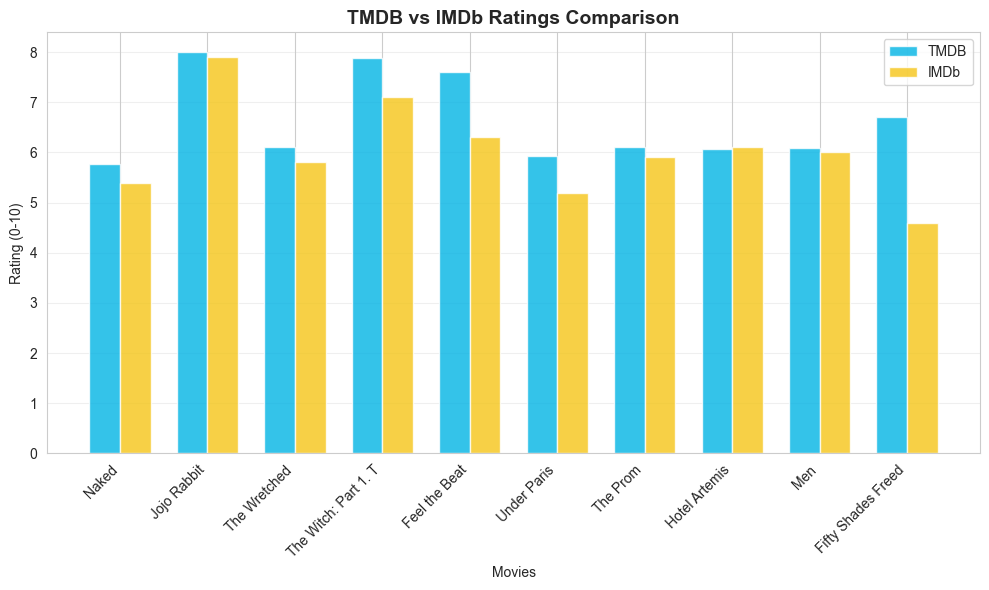

: 

: 

: 

: 

: 

In [ ]:
# Fetch updated movies
db = SessionLocal()
scraped_movies = db.query(Movie).filter(Movie.imdb_rating.isnot(None)).limit(TEST_MOVIES).all()
db.close()

if scraped_movies:
    print("📊 RATING COMPARISON (TMDB vs IMDb)")
    print("=" * 80)
    
    comparison_data = []
    for movie in scraped_movies:
        rating_info = movie.get_rating_metadata()
        
        print(f"\n🎬 {movie.title} ({movie.release_year})")
        print(f"   TMDB Rating:  {movie.tmdb_rating or 'N/A'}/10 ({movie.tmdb_vote_count or 0:,} votes)")
        print(f"   IMDb Rating:  {movie.imdb_rating or 'N/A'}/10 ({movie.imdb_vote_count or 0:,} votes)")
        print(f"   Best Rating:  {rating_info['recommended_rating']}/10")
        
        if movie.tmdb_rating and movie.imdb_rating:
            diff = abs(movie.tmdb_rating - movie.imdb_rating)
            print(f"   Difference:   {diff:.2f} points")
        
        comparison_data.append({
            'title': movie.title,
            'tmdb': movie.tmdb_rating,
            'imdb': movie.imdb_rating,
            'best': rating_info['recommended_rating']
        })
    
    # Visualization
    df_comparison = pd.DataFrame(comparison_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(df_comparison))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], df_comparison['tmdb'], width, label='TMDB', alpha=0.8, color='#01b4e4')
    ax.bar([i + width/2 for i in x], df_comparison['imdb'], width, label='IMDb', alpha=0.8, color='#f5c518')
    
    ax.set_xlabel('Movies')
    ax.set_ylabel('Rating (0-10)')
    ax.set_title('TMDB vs IMDb Ratings Comparison', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([t[:20] for t in df_comparison['title']], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No scraped movies found with IMDb ratings")

In [ ]:
# Get comprehensive review data summary
db = SessionLocal()

# Get all reviews
all_reviews = db.query(Review).all()

if all_reviews:
    print("? COMPREHENSIVE REVIEW DATA SUMMARY")
    print("=" * 80)
    
    # Overall stats by source
    imdb_reviews = [r for r in all_reviews if r.source == 'imdb']
    rt_reviews = [r for r in all_reviews if r.source == 'rotten_tomatoes']
    
    print(f"\n? Overall Statistics:")
    print(f"   Total reviews: {len(all_reviews)}")
    print(f"   IMDb reviews: {len(imdb_reviews)}")
    print(f"   Rotten Tomatoes reviews: {len(rt_reviews)}")
    
    if imdb_reviews:
        total_helpful = sum(r.helpful_count or 0 for r in imdb_reviews)
        avg_length = sum(r.review_length or 0 for r in imdb_reviews) / len(imdb_reviews)
        avg_rating = sum(r.rating or 0 for r in imdb_reviews if r.rating) / max(len([r for r in imdb_reviews if r.rating]), 1)
        
        print(f"\n⭐ IMDb Review Metrics:")
        print(f"   Total helpful votes: {total_helpful:,}")
        print(f"   Average review length: {avg_length:.0f} characters")
        print(f"   Average rating: {avg_rating:.2f}/10")
        print(f"   Average words per review: {sum(r.word_count or 0 for r in imdb_reviews) / len(imdb_reviews):.0f}")
    
    if rt_reviews:
        avg_length_rt = sum(r.review_length or 0 for r in rt_reviews) / len(rt_reviews)
        critic_reviews = [r for r in rt_reviews if 'critic' in (r.source_id or '')]
        audience_reviews = [r for r in rt_reviews if 'audience' in (r.source_id or '')]
        
        print(f"\n🍅 Rotten Tomatoes Metrics:")
        print(f"   Critic reviews: {len(critic_reviews)}")
        print(f"   Audience reviews: {len(audience_reviews)}")
        print(f"   Average review length: {avg_length_rt:.0f} characters")
        print(f"   Average words per review: {sum(r.word_count or 0 for r in rt_reviews) / len(rt_reviews):.0f}")
    
    # Per movie breakdown
    print(f"\n\n🎬 Reviews Per Movie:")
    print("-" * 80)
    
    movies_with_reviews = db.query(Movie).join(Review).distinct().all()
    
    for movie in movies_with_reviews:
        movie_reviews = [r for r in all_reviews if r.movie_id == movie.id]
        imdb_count = len([r for r in movie_reviews if r.source == 'imdb'])
        rt_count = len([r for r in movie_reviews if r.source == 'rotten_tomatoes'])
        
        if imdb_count > 0 or rt_count > 0:
            print(f"\n📽️  {movie.title} ({movie.release_year})")
            print(f"   Total reviews: {len(movie_reviews)}")
            print(f"   IMDb: {imdb_count} | Rotten Tomatoes: {rt_count}")
            
            # Sample review
            sample = movie_reviews[0] if movie_reviews else None
            if sample:
                text_preview = sample.text[:100] + "..." if len(sample.text) > 100 else sample.text
                source_name = "IMDb" if sample.source == 'imdb' else "Rotten Tomatoes"
                print(f"   📌 Sample ({source_name}): \"{text_preview}\"")
    
    # Create visualization: Reviews per movie
    if len(movies_with_reviews) > 0:
        print(f"\n📊 Creating visualization...")
        
        movie_review_counts = {}
        movie_sources = {}
        
        for movie in movies_with_reviews:
            reviews = [r for r in all_reviews if r.movie_id == movie.id]
            if reviews:
                movie_name = movie.title[:20]
                movie_review_counts[movie_name] = len(reviews)
                imdb_cnt = len([r for r in reviews if r.source == 'imdb'])
                rt_cnt = len([r for r in reviews if r.source == 'rotten_tomatoes'])
                movie_sources[movie_name] = {'imdb': imdb_cnt, 'rt': rt_cnt}
        
        if movie_review_counts:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Reviews per movie - stacked bar
            movies = list(movie_review_counts.keys())
            imdb_counts = [movie_sources[m]['imdb'] for m in movies]
            rt_counts = [movie_sources[m]['rt'] for m in movies]
            
            ax1.barh(movies, imdb_counts, label='IMDb', color='#f5c518')
            ax1.barh(movies, rt_counts, left=imdb_counts, label='Rotten Tomatoes', color='#fa320a')
            ax1.set_xlabel('Number of Reviews')
            ax1.set_title('Reviews per Movie (by Source)', fontweight='bold', fontsize=14)
            ax1.legend()
            ax1.invert_yaxis()
            
            # Review length distribution
            review_lengths = [r.review_length for r in all_reviews if r.review_length]
            if review_lengths:
                ax2.hist(review_lengths, bins=30, color='#4CAF50', alpha=0.7, edgecolor='black')
                ax2.set_xlabel('Review Length (characters)')
                ax2.set_ylabel('Number of Reviews')
                ax2.set_title('Review Length Distribution', fontweight='bold', fontsize=14)
                ax2.axvline(sum(review_lengths)/len(review_lengths), color='red', linestyle='--', 
                           label=f'Mean: {sum(review_lengths)/len(review_lengths):.0f} chars')
                ax2.legend()
            
            plt.tight_layout()
            plt.show()
    
    print("\n" + "=" * 80)
    
else:
    print("? No review data collected yet")
    print("   Run Steps 11a and 11b to scrape IMDb and Rotten Tomatoes reviews")

db.close()

📱 No social media data collected yet
   Run Step 11b to scrape Twitter data


: 

: 

: 

: 

: 

## ✅ Quick Test with Full Scraping Complete!

**What we tested:**
- ✅ CSV loading and parsing (random selection)
- ✅ Database operations with auto-clearing
- ✅ Random movie selection for scraping
- ✅ IMDb rating scraping (concurrent - up to 3 at once)
- ✅ **IMDb review scraping (concurrent - up to 3 at once, 30 reviews per movie)**
- ✅ **Rotten Tomatoes review scraping (concurrent - up to 3 at once, 20 reviews per movie)**
- ✅ Rating comparison logic (TMDB vs IMDb)
- ✅ Smart rating selection
- ✅ **Multi-source review analysis and visualization**

**Performance:**
- 🚀 Concurrent scraping speeds up the process significantly
- 🎲 Random movie selection ensures variety in testing
- ⚡ ThreadPoolExecutor manages parallel requests efficiently
- 💰 No OpenAI API calls needed for IMDb/RT scraping (saves credits!)

**Data Sources:**
- 📊 TMDB: Ratings from CSV dataset
- 🎬 IMDb: Live scraped ratings + **detailed user reviews**
- 🍅 Rotten Tomatoes: **Critic and audience reviews**
- 🔮 OpenAI: Reserved for Reddit search term generation (future feature)

**Review Collection:**
- 📝 IMDb reviews include: title, text, rating (1-10), author, date, helpful votes
- 🍅 RT reviews include: critic/audience distinction, text, author, date
- 📊 Comprehensive review analytics and visualizations

**OpenAI Usage:**
- 💡 OpenAI API credits ($10) saved for Reddit scraping when you get API access
- ⚡ IMDb and RT scrapers work directly without needing OpenAI
- 🎯 Efficient use of API credits only where truly needed

**Next Steps:**
1. Run full pipeline on more movies
2. Scale to full dataset (2000 movies) with concurrent processing
3. **Get Reddit API credentials and enable Step 11c for Reddit discussions**
4. Implement sentiment analysis on review data
5. Build recommendation models using hybrid data sources (TMDB + IMDb + RT reviews + Reddit)

## 🔍 Interactive Database Viewer

View and explore the database contents in real-time!

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd

# Interactive Database Viewer
class DatabaseViewer:
    def __init__(self):
        self.db = SessionLocal()
        
        # Create dropdown for table selection
        self.table_selector = widgets.Dropdown(
            options=['Movies', 'Reviews', 'Search Terms', 'Summary'],
            value='Movies',
            description='View:',
            style={'description_width': '100px'}
        )
        
        # Create filter inputs
        self.search_box = widgets.Text(
            placeholder='Search by title...',
            description='Filter:',
            style={'description_width': '100px'}
        )
        
        # Create refresh button
        self.refresh_btn = widgets.Button(
            description='🔄 Refresh',
            button_style='info',
            tooltip='Reload data from database'
        )
        
        # Create output area
        self.output = widgets.Output()
        
        # Set up event handlers
        self.table_selector.observe(self.on_table_change, names='value')
        self.search_box.observe(self.on_search, names='value')
        self.refresh_btn.on_click(self.on_refresh)
        
        # Display initial view
        self.show_view()
    
    def get_movies_df(self):
        """Get movies as DataFrame"""
        movies = self.db.query(Movie).all()
        if not movies:
            return pd.DataFrame()
        
        data = []
        for m in movies:
            review_count = self.db.query(Review).filter(Review.movie_id == m.id).count()
            data.append({
                'ID': m.id,
                'Title': m.title,
                'Year': m.release_year,
                'Genres': m.genres[:30] + '...' if m.genres and len(m.genres) > 30 else m.genres,
                'TMDB': f"{m.tmdb_rating:.1f}" if m.tmdb_rating else 'N/A',
                'IMDb': f"{m.imdb_rating:.1f}" if m.imdb_rating else 'N/A',
                'Reviews': review_count,
                'Scraped': '✅' if m.scraped_at else '❌'
            })
        return pd.DataFrame(data)
    
    def get_reviews_df(self):
        """Get reviews as DataFrame"""
        reviews = self.db.query(Review).order_by(Review.scraped_at.desc()).limit(100).all()
        if not reviews:
            return pd.DataFrame()
        
        data = []
        for r in reviews:
            movie = self.db.query(Movie).filter(Movie.id == r.movie_id).first()
            data.append({
                'Movie': movie.title if movie else 'Unknown',
                'Source': r.source.upper(),
                'Author': r.author[:20] + '...' if r.author and len(r.author) > 20 else r.author or 'Anonymous',
                'Rating': r.rating if r.rating else 'N/A',
                'Length': r.review_length,
                'Words': r.word_count,
                'Helpful': r.helpful_count or 0,
                'Date': r.review_date.strftime('%Y-%m-%d') if r.review_date else 'N/A',
                'Preview': r.text[:60] + '...' if r.text else ''
            })
        return pd.DataFrame(data)
    
    def get_search_terms_df(self):
        """Get search terms as DataFrame"""
        terms = self.db.query(MovieSearchTerm).all()
        if not terms:
            return pd.DataFrame()
        
        data = []
        for t in terms:
            movie = self.db.query(Movie).filter(Movie.id == t.movie_id).first()
            data.append({
                'Movie': movie.title if movie else 'Unknown',
                'Search Term': t.search_term,
                'Source': t.source,
                'Created': t.created_at.strftime('%Y-%m-%d %H:%M') if t.created_at else 'N/A'
            })
        return pd.DataFrame(data)
    
    def get_summary_stats(self):
        """Get database summary statistics"""
        movie_count = self.db.query(Movie).count()
        review_count = self.db.query(Review).count()
        search_term_count = self.db.query(MovieSearchTerm).count()
        
        # Count by source
        imdb_reviews = self.db.query(Review).filter(Review.source == 'imdb').count()
        rt_reviews = self.db.query(Review).filter(Review.source == 'rotten_tomatoes').count()
        
        # Movies with ratings
        movies_with_imdb = self.db.query(Movie).filter(Movie.imdb_rating.isnot(None)).count()
        movies_with_tmdb = self.db.query(Movie).filter(Movie.tmdb_rating.isnot(None)).count()
        
        return {
            'Total Movies': movie_count,
            'Movies with TMDB Rating': movies_with_tmdb,
            'Movies with IMDb Rating': movies_with_imdb,
            'Total Reviews': review_count,
            'IMDb Reviews': imdb_reviews,
            'Rotten Tomatoes Reviews': rt_reviews,
            'Search Terms Generated': search_term_count
        }
    
    def on_table_change(self, change):
        """Handle table selection change"""
        self.show_view()
    
    def on_search(self, change):
        """Handle search input"""
        self.show_view()
    
    def on_refresh(self, button):
        """Handle refresh button click"""
        self.db.close()
        self.db = SessionLocal()
        self.show_view()
    
    def show_view(self):
        """Display selected view"""
        with self.output:
            self.output.clear_output()
            
            table = self.table_selector.value
            search_text = self.search_box.value.lower()
            
            if table == 'Movies':
                df = self.get_movies_df()
                if not df.empty and search_text:
                    df = df[df['Title'].str.lower().str.contains(search_text, na=False)]
                
                print(f"📊 Total Movies: {len(df)}")
                if not df.empty:
                    display(df.style.set_properties(**{
                        'text-align': 'left',
                        'white-space': 'nowrap'
                    }).set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left')]}
                    ]))
                else:
                    print("No movies found in database. Run Steps 5-10 to load movies.")
            
            elif table == 'Reviews':
                df = self.get_reviews_df()
                if not df.empty and search_text:
                    df = df[df['Movie'].str.lower().str.contains(search_text, na=False)]
                
                print(f"📝 Total Reviews (last 100): {len(df)}")
                if not df.empty:
                    display(df.style.set_properties(**{
                        'text-align': 'left',
                        'white-space': 'nowrap'
                    }).set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left')]}
                    ]))
                else:
                    print("No reviews found. Run Steps 11a and 11b to scrape reviews.")
            
            elif table == 'Search Terms':
                df = self.get_search_terms_df()
                if not df.empty and search_text:
                    df = df[df['Movie'].str.lower().str.contains(search_text, na=False)]
                
                print(f"🔍 Total Search Terms: {len(df)}")
                if not df.empty:
                    display(df)
                else:
                    print("No search terms found. Run Step 11c when Reddit API is available.")
            
            elif table == 'Summary':
                stats = self.get_summary_stats()
                print("📊 DATABASE SUMMARY")
                print("=" * 60)
                for key, value in stats.items():
                    print(f"{key:.<40} {value:>10,}")
    
    def display(self):
        """Display the viewer UI"""
        controls = widgets.HBox([self.table_selector, self.search_box, self.refresh_btn])
        display(widgets.VBox([controls, self.output]))
    
    def __del__(self):
        """Cleanup database connection"""
        if hasattr(self, 'db'):
            self.db.close()

# Create and display the viewer
print("🔍 Interactive Database Viewer")
print("=" * 60)
viewer = DatabaseViewer()
viewer.display()

In [15]:
# Check if not_helpful_count field exists in database
import sqlite3

# Connect to database
conn = sqlite3.connect(project_root / 'data' / 'database' / 'movie_recommender.db')
cursor = conn.cursor()

# Check schema
cursor.execute("PRAGMA table_info(reviews)")
columns = cursor.fetchall()

print("📋 Reviews table schema:")
for col in columns:
    print(f"  {col[1]:25s} {col[2]:10s} (nullable: {col[3] == 0})")

# Query a sample review
cursor.execute("SELECT source, helpful_count, not_helpful_count FROM reviews LIMIT 1")
sample = cursor.fetchone()

if sample:
    print(f"\n✅ Sample review data:")
    print(f"  Source: {sample[0]}")
    print(f"  Helpful: {sample[1]}")
    print(f"  Not Helpful: {sample[2]}")
else:
    print("\n⚠️  No reviews in database yet")

conn.close()

📋 Reviews table schema:
  id                        INTEGER    (nullable: False)
  movie_id                  INTEGER    (nullable: False)
  source                    VARCHAR(50) (nullable: False)
  source_id                 VARCHAR(200) (nullable: True)
  text                      TEXT       (nullable: False)
  rating                    FLOAT      (nullable: True)
  title                     VARCHAR(500) (nullable: True)
  author                    VARCHAR(200) (nullable: True)
  author_id                 VARCHAR(200) (nullable: True)
  upvotes                   INTEGER    (nullable: True)
  downvotes                 INTEGER    (nullable: True)
  helpful_count             INTEGER    (nullable: True)
  not_helpful_count         INTEGER    (nullable: True)
  reply_count               INTEGER    (nullable: True)
  review_date               DATETIME   (nullable: True)
  scraped_at                DATETIME   (nullable: True)
  review_length             INTEGER    (nullable: True)
  word_coun

In [16]:
# Export reviews to CSV with not_helpful_count field
from datetime import datetime

reviews = db.query(Review).all()
if reviews:
    df_reviews = pd.DataFrame([{
        'movie_id': r.movie_id,
        'source': r.source,
        'author': r.author,
        'rating': r.rating,
        'text': r.text,
        'review_date': r.review_date,
        'helpful_count': r.helpful_count,
        'not_helpful_count': r.not_helpful_count,  # ✅ NOW INCLUDED!
        'word_count': r.word_count
    } for r in reviews])
    
    export_dir = project_root / 'exports'
    export_dir.mkdir(exist_ok=True)
    
    reviews_file = export_dir / f"reviews_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df_reviews.to_csv(reviews_file, index=False)
    
    print(f"✅ Exported {len(reviews):,} reviews to:")
    print(f"   {reviews_file}")
    print(f"\n📋 Columns exported:")
    for col in df_reviews.columns:
        print(f"   - {col}")
else:
    print("⚠️  No reviews in database to export")

✅ Exported 431 reviews to:
   /Users/rachitasaini/Desktop/Rutgers/Fall 2026/Intro to Data Science 01-198-439/project/hybrid-rec-sys/exports/reviews_20251207_225729.csv

📋 Columns exported:
   - movie_id
   - source
   - author
   - rating
   - text
   - review_date
   - helpful_count
   - not_helpful_count
   - word_count
